In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch
import pickle

def save_graph_rag_system(
    model,
    proto_matrix,
    adjacency,
    diseases,
    graph,
    save_dir="saved_graph_rag"
):
    import os
    os.makedirs(save_dir, exist_ok=True)

    # 1️⃣ Save model
    torch.save(
        model.state_dict(),
        f"{save_dir}/cnn_weights.pth"
    )

    # 2️⃣ Save core tensors
    torch.save({
        "proto_matrix": proto_matrix.cpu(),
        "adjacency": adjacency.cpu(),
        "diseases": diseases
    }, f"{save_dir}/graph_core.pth")

    # 3️⃣ Save graph index
    with open(f"{save_dir}/graph_index.pkl", "wb") as f:
        pickle.dump(graph, f)

    # 4️⃣ Save preprocessing config
    preprocess_cfg = {
        "image_size": 224,
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225]
    }

    with open(f"{save_dir}/preprocess.pkl", "wb") as f:
        pickle.dump(preprocess_cfg, f)

    print("✅ Graph-RAG system saved successfully")


In [5]:
import torch
import pickle

def load_graph_rag_system(
    model,
    device,
    save_dir="saved_graph_rag"
):
    # 1️⃣ Load model weights
    model.load_state_dict(
        torch.load(f"{save_dir}/cnn_weights.pth", map_location=device)
    )
    model.eval()

    # 2️⃣ Load core graph tensors
    core = torch.load(
        f"{save_dir}/graph_core.pth",
        map_location=device
    )

    proto_matrix = core["proto_matrix"].to(device)
    adjacency = core["adjacency"].to(device)
    diseases = core["diseases"]

    # 3️⃣ Load graph index
    with open(f"{save_dir}/graph_index.pkl", "rb") as f:
        graph = pickle.load(f)

    # 4️⃣ Load preprocessing config
    with open(f"{save_dir}/preprocess.pkl", "rb") as f:
        preprocess_cfg = pickle.load(f)

    print("✅ Graph-RAG system loaded successfully")

    return {
        "model": model,
        "proto_matrix": proto_matrix,
        "adjacency": adjacency,
        "diseases": diseases,
        "graph": graph,
        "preprocess": preprocess_cfg
    }


In [ ]:
# Make sure model is in eval mode
model.eval()

# Call the save function
save_graph_rag_system(
    model=model,
    proto_matrix=proto_matrix,
    adjacency=A,
    diseases=diseases,
    graph=graph,
    save_dir="saved_graph_rag"
)

In [ ]:
# Recreate model architecture
model = DenseNet121_new(num_classes=14).to(device)

system = load_graph_rag_system(model, device)

model = system["model"]
proto_matrix = system["proto_matrix"]
graph = system["graph"]
diseases = system["diseases"]


In [ ]:
!pip install -q kaggle


In [6]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("nih-chest-xrays/data")

# print("Path to dataset files:", path)
path='/kaggle/input/data'

In [7]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/data


In [8]:
import os

for root, dirs, files in os.walk(path, topdown=True):
    print(root, dirs, files)
    break


/kaggle/input/data ['images_003', 'images_012', 'images_009', 'images_008', 'images_007', 'images_010', 'images_002', 'images_011', 'images_001', 'images_005', 'images_004', 'images_006'] ['LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'test_list.txt', 'ARXIV_V5_CHESTXRAY.pdf', 'Data_Entry_2017.csv', 'train_val_list.txt', 'FAQ_CHESTXRAY.pdf']


In [9]:
bbox_csv = os.path.join(path, 'BBox_List_2017.csv')
data_csv = os.path.join(path, 'Data_Entry_2017.csv')

In [10]:
bbox_pd=pd.read_csv(bbox_csv)
data_pd=pd.read_csv(data_csv)

In [9]:
data_pd.shape

(112120, 12)

#data_csv is : 112120*12

In [10]:
data_pd.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [11]:
import os

image_folders = []
for i in range(1, 13): # Loop from 1 to 12
    folder_name = f'images_{i:03d}' # Format as images_001, images_002, ..., images_012
    folder_path = os.path.join(path, folder_name)
    image_folders.append(folder_path)

# You can uncomment the following lines to print the paths and verify
# for folder in image_folders:
#     print(folder)

In [12]:
image_folders[0]

'/kaggle/input/data/images_001'

In [13]:
data_pd.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

#The Path is the path of the .jpg file of that patient .
Here view 1 is frontal and view 2 is lateral

The patient are in order number

Each patient have different number of studies

Each study has the image either frontal or lateral or both

In [12]:
for i in range (0,12):
  # Get the base folder name (e.g., 'images_001') for better readability in the output
  folder_name_display = os.path.basename(image_folders[i])
  print(f"  Number of files in {folder_name_display} is {len(os.listdir(os.path.join(image_folders[i],'images')))}")

  Number of files in images_001 is 4999
  Number of files in images_002 is 10000
  Number of files in images_003 is 10000
  Number of files in images_004 is 10000
  Number of files in images_005 is 10000
  Number of files in images_006 is 10000
  Number of files in images_007 is 10000
  Number of files in images_008 is 10000
  Number of files in images_009 is 10000
  Number of files in images_010 is 10000
  Number of files in images_011 is 10000
  Number of files in images_012 is 7121


In [33]:
data_pd["Patient Gender"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 112120 entries, 0 to 112119
Series name: Patient Gender
Non-Null Count   Dtype 
--------------   ----- 
112120 non-null  object
dtypes: object(1)
memory usage: 876.1+ KB


In [34]:
data_pd["Patient Gender"].value_counts()

Patient Gender
M    63340
F    48780
Name: count, dtype: int64

In [35]:
data_pd["Patient Age"]

0         58
1         58
2         58
3         81
4         81
          ..
112115    39
112116    29
112117    42
112118    30
112119    27
Name: Patient Age, Length: 112120, dtype: int64

In [36]:
data_pd["Patient Age"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 112120 entries, 0 to 112119
Series name: Patient Age
Non-Null Count   Dtype
--------------   -----
112120 non-null  int64
dtypes: int64(1)
memory usage: 876.1 KB


In [37]:
data_pd["Patient Age"].value_counts()

Patient Age
58     3209
56     2916
52     2891
55     2830
57     2771
       ... 
411       1
150       1
149       1
95        1
152       1
Name: count, Length: 107, dtype: int64

In [13]:
data_pd[data_pd["Patient Age"]>100]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN


In [14]:
data_pd["Patient Age"].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

In [15]:
data_clean_pd = data_pd.copy()
data_clean_pd['Patient Age'] = data_clean_pd['Patient Age'].clip(upper=120)


In [16]:
data_clean_pd['Patient Age']

0         58
1         58
2         58
3         81
4         81
          ..
112115    39
112116    29
112117    42
112118    30
112119    27
Name: Patient Age, Length: 112120, dtype: int64

In [18]:
data_clean_pd['Patient Age'].max()

120

In [17]:
age_stats = data_clean_pd['Patient Age'].describe()
print(age_stats)


count    112120.000000
mean         46.883009
std          16.619939
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         120.000000
Name: Patient Age, dtype: float64


In [18]:
data_clean_pd[data_clean_pd['Patient Age']>=100]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,120,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,120,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,120,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,120,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,120,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,120,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,120,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,120,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,120,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,120,M,AP,3056,2544,0.139,0.139,NaN


In [19]:
# from numpy._core.multiarray import concatenate
# result_horizontal = pd.concat([df1, df2], axis=1)
data_clean_pd = pd.concat([data_clean_pd,pd.DataFrame(columns=['age_group'])],axis=1)

In [21]:
data_clean_pd

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,age_group
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,NaN


In [20]:
bins = [0, 18, 35, 60, 100,121]
labels = ['Youth', 'Adult', 'Middle Age', 'Senior',"Very Senior"]

# Re-initialize data_clean_pd with Patient Age and apply clipping
# data_clean_pd = data_pd.copy()
# data_clean_pd['Patient Age'] = data_clean_pd['Patient Age'].clip(upper=120)

# Create a new categorical column

data_clean_pd['age_group'] = pd.cut(data_clean_pd['Patient Age'], bins=bins, labels=labels, right=False)

# View the frequency of each group
age_group_counts = data_clean_pd['age_group'].value_counts()
print(age_group_counts)

age_group
Middle Age     57060
Senior         27032
Adult          22771
Youth           5241
Very Senior       16
Name: count, dtype: int64


In [21]:
data_pd["View Position"].describe()

count     112120
unique         2
top           PA
freq       67310
Name: View Position, dtype: object

In [49]:
data_pd["Follow-up #"]

0         0
1         1
2         2
3         0
4         0
         ..
112115    1
112116    0
112117    0
112118    0
112119    0
Name: Follow-up #, Length: 112120, dtype: int64

In [50]:
data_pd["Follow-up #"].describe()

count    112120.000000
mean          8.573751
std          15.406320
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64

In [51]:
data_pd["Finding Labels"]

0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                     No Finding
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                No Finding
112117                No Finding
112118                No Finding
112119                No Finding
Name: Finding Labels, Length: 112120, dtype: object

In [52]:
data_pd['Finding Labels'].value_counts()

Finding Labels
No Finding                                                                      60361
Infiltration                                                                     9547
Atelectasis                                                                      4215
Effusion                                                                         3955
Nodule                                                                           2705
                                                                                ...  
Consolidation|Edema|Effusion|Mass|Nodule                                            1
Edema|Infiltration|Mass|Pneumonia|Pneumothorax                                      1
Consolidation|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia        1
Consolidation|Mass|Nodule|Pneumothorax                                              1
Cardiomegaly|Edema|Effusion|Fibrosis|Infiltration                                   1
Name: count, Length: 836, dtype: int64

In [53]:
data_pd['Finding Labels'].describe()

count         112120
unique           836
top       No Finding
freq           60361
Name: Finding Labels, dtype: object

In [22]:
diseases = [


            'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
    'Consolidation', 'Edema', 'Emphysema',
    'Fibrosis', 'Pleural_Thickening', 'Hernia'
]


In [23]:
# One-hot encode diseases
for d in diseases:
    data_clean_pd[d] = data_clean_pd['Finding Labels'].str.contains(d).astype(int)

# One-hot encode No Finding
data_clean_pd['No_Finding'] = (data_clean_pd['Finding Labels'] == 'No Finding').astype(int)

# Ensure correctness: No Finding => all disease labels = 0
data_clean_pd.loc[data_clean_pd['No_Finding'] == 1, diseases] = 0


In [24]:
data_clean_pd.drop(columns=['No_Finding'], inplace=True)

In [25]:
data_clean_pd.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'age_group', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
       'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
       'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'],
      dtype='object')

In [58]:
data_clean_pd.shape

(112120, 27)

In [59]:
data_clean_pd["Unnamed: 11"]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
112115   NaN
112116   NaN
112117   NaN
112118   NaN
112119   NaN
Name: Unnamed: 11, Length: 112120, dtype: float64

In [26]:
data_clean_pd = data_clean_pd.drop(columns=['Unnamed: 11'])


In [27]:
data_clean_pd["Image Index"]

0         00000001_000.png
1         00000001_001.png
2         00000001_002.png
3         00000002_000.png
4         00000003_000.png
                ...       
112115    00030801_001.png
112116    00030802_000.png
112117    00030803_000.png
112118    00030804_000.png
112119    00030805_000.png
Name: Image Index, Length: 112120, dtype: object

# 1 row for each photo

In [28]:
data_clean_pd["Patient ID"]

0             1
1             1
2             1
3             2
4             3
          ...  
112115    30801
112116    30802
112117    30803
112118    30804
112119    30805
Name: Patient ID, Length: 112120, dtype: int64

In [63]:
data_clean_pd["Patient ID"].value_counts()

Patient ID
10007    184
13670    173
15530    158
12834    157
13993    143
        ... 
30777      1
30778      1
30779      1
30780      1
30781      1
Name: count, Length: 30805, dtype: int64

In [64]:
print(f'Total number of patients is {len(data_clean_pd["Patient ID"].value_counts())}')

Total number of patients is 30805


In [29]:
data_clean_pd.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'age_group',
       'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
       'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
       'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'],
      dtype='object')

In [30]:
disease_counts = data_clean_pd[diseases].sum().sort_values(ascending=False)
print(disease_counts)


Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64


In [67]:
print(disease_counts/1121.20)

Infiltration          17.743489
Effusion              11.877453
Atelectasis           10.309490
Nodule                 5.646629
Mass                   5.156975
Pneumothorax           4.728862
Consolidation          4.162504
Pleural_Thickening     3.019087
Cardiomegaly           2.475919
Emphysema              2.244024
Edema                  2.054049
Fibrosis               1.503746
Pneumonia              1.276311
Hernia                 0.202462
dtype: float64


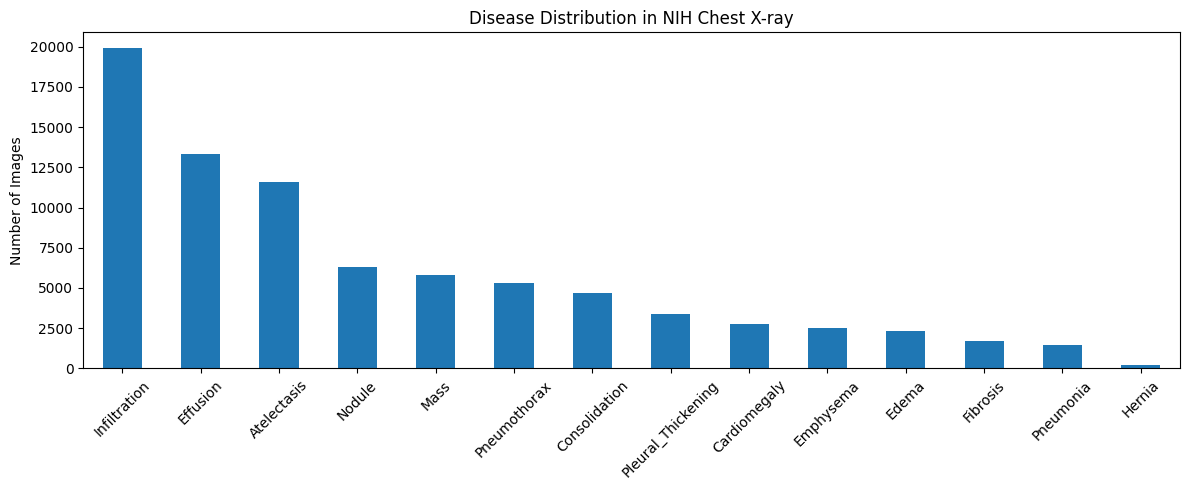

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
disease_counts.plot(kind='bar')
plt.title("Disease Distribution in NIH Chest X-ray")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
data_clean_pd['num_diseases'] = data_clean_pd[diseases].sum(axis=1)

data_clean_pd['num_diseases'].value_counts().sort_index()


num_diseases
0    60361
1    30963
2    14306
3     4856
4     1247
5      301
6       67
7       16
8        1
9        2
Name: count, dtype: int64

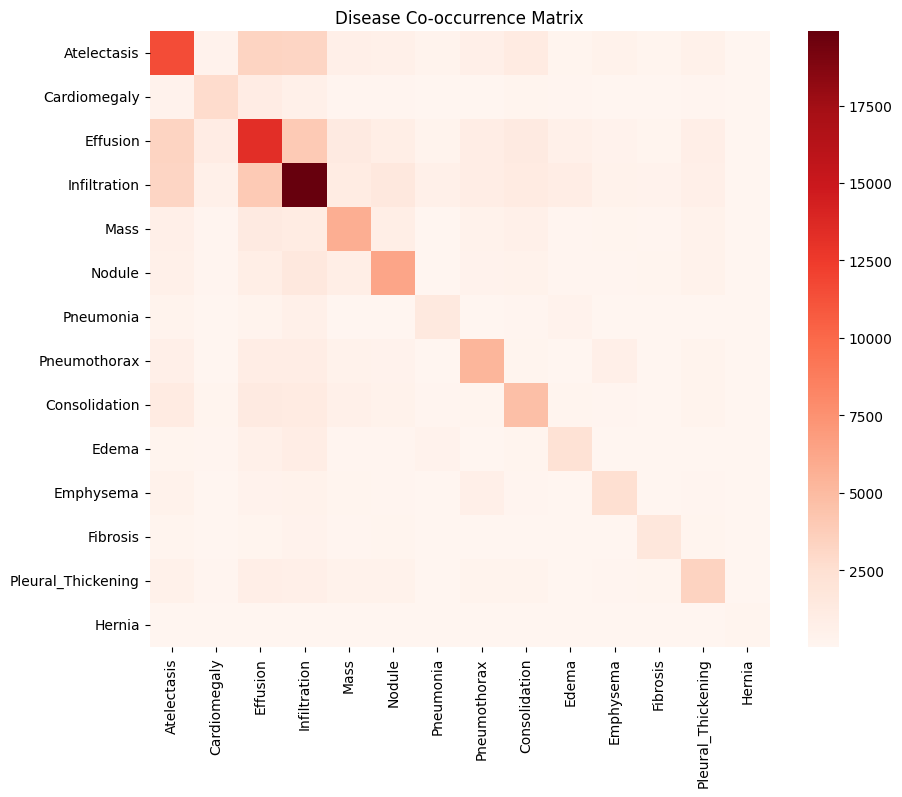

In [70]:
import seaborn as sns
import numpy as np

co_matrix = np.dot(
    data_clean_pd[diseases].T,
    data_clean_pd[diseases]
)

co_df = pd.DataFrame(co_matrix, index=diseases, columns=diseases)

plt.figure(figsize=(10,8))
sns.heatmap(co_df, cmap='Reds')
plt.title("Disease Co-occurrence Matrix")
plt.show()


#To overecome class imbalance

In [32]:
import numpy as np

pos_counts = disease_counts.values
neg_counts = len(data_clean_pd) - pos_counts

class_weights = neg_counts / (pos_counts + 1e-6)
class_weights = class_weights / class_weights.mean()  # normalize

class_weights


array([0.07230978, 0.11572561, 0.13569851, 0.26063573, 0.28686407,
       0.31424652, 0.35912572, 0.50104467, 0.61438592, 0.67948759,
       0.7437747 , 1.02167083, 1.20650907, 7.68852127])

#loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights))
can use the above weight thing in the training

# Test Train Validation Dataset Creation

In [33]:
import numpy as np

patient_ids = data_clean_pd["Patient ID"].unique()
print("Total patients:", len(patient_ids))


Total patients: 30805


In [34]:
np.random.seed(42)
np.random.shuffle(patient_ids)


In [35]:
n_patients = len(patient_ids)

train_end = int(0.70 * n_patients)
val_end   = int(0.85 * n_patients)

train_patients = patient_ids[:train_end]
val_patients   = patient_ids[train_end:val_end]
test_patients  = patient_ids[val_end:]


In [36]:
train_df = data_clean_pd[data_clean_pd["Patient ID"].isin(train_patients)].reset_index(drop=True)
val_df   = data_clean_pd[data_clean_pd["Patient ID"].isin(val_patients)].reset_index(drop=True)
test_df  = data_clean_pd[data_clean_pd["Patient ID"].isin(test_patients)].reset_index(drop=True)

print("Train images:", len(train_df))
print("Val images:", len(val_df))
print("Test images:", len(test_df))


Train images: 78708
Val images: 16758
Test images: 16654


In [37]:
assert set(train_df["Patient ID"]).isdisjoint(val_df["Patient ID"])
assert set(train_df["Patient ID"]).isdisjoint(test_df["Patient ID"])
assert set(val_df["Patient ID"]).isdisjoint(test_df["Patient ID"])

print("✅ No patient leakage between splits")


✅ No patient leakage between splits


In [38]:
labels = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration',
    'Mass','Nodule','Pneumonia','Pneumothorax',
    'Consolidation','Edema','Emphysema','Fibrosis',
    'Pleural_Thickening','Hernia'
]

def label_stats(df, name):
    print(f"\n{name} label counts:")
    print(df[labels].sum())

label_stats(train_df, "Train")
label_stats(val_df, "Validation")
label_stats(test_df, "Test")



Train label counts:
Atelectasis            7996
Cardiomegaly           1958
Effusion               9267
Infiltration          14203
Mass                   3947
Nodule                 4457
Pneumonia              1035
Pneumothorax           3809
Consolidation          3252
Edema                  1632
Emphysema              1809
Fibrosis               1174
Pleural_Thickening     2337
Hernia                  174
dtype: int64

Validation label counts:
Atelectasis           1816
Cardiomegaly           376
Effusion              1905
Infiltration          2772
Mass                   936
Nodule                 908
Pneumonia              193
Pneumothorax           829
Consolidation          677
Edema                  289
Emphysema              359
Fibrosis               293
Pleural_Thickening     519
Hernia                  29
dtype: int64

Test label counts:
Atelectasis           1747
Cardiomegaly           442
Effusion              2145
Infiltration          2919
Mass                   899
No

In [39]:
train_df.to_csv("train_patient_split.csv", index=False)
val_df.to_csv("val_patient_split.csv", index=False)
test_df.to_csv("test_patient_split.csv", index=False)


Now Time for training

In [40]:
import torch

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [42]:
import os

def build_image_index(image_root):
    image_index = {}
    for root, _, files in os.walk(image_root):
        for f in files:
            if f.endswith(".png") or f.endswith(".jpg"):
                image_index[f] = os.path.join(root, f)
    return image_index


In [43]:
IMAGE_ROOT = path  # dataset root from kagglehub
image_index = build_image_index(IMAGE_ROOT)

print("Total images indexed:", len(image_index))


Total images indexed: 112120


In [44]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [45]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class ChestXrayDataset(Dataset):
    def __init__(self, df, image_index, transform=None, label_cols=None):
        self.df = df.reset_index(drop=True)
        self.image_index = image_index
        self.transform = transform
        self.label_cols = label_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # --- Load image ---
        image_name = row["Image Index"]
        image_path = self.image_index[image_name]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # --- Load labels ---
        labels = row[self.label_cols].values.astype("float32")
        labels = torch.tensor(labels)

        return image, labels


In [46]:
# label_cols = [
#     'Atelectasis','Cardiomegaly','Effusion','Infiltration',
#     'Mass','Nodule','Pneumonia','Pneumothorax',
#     'Consolidation','Edema','Emphysema','Fibrosis',
#     'Pleural_Thickening','Hernia'
# ]

train_dataset = ChestXrayDataset(
    train_df, image_index,
    transform=train_transform,
    label_cols=diseases
)

val_dataset = ChestXrayDataset(
    val_df, image_index,
    transform=val_test_transform,
    label_cols=diseases
)

test_dataset = ChestXrayDataset(
    test_df, image_index,
    transform=val_test_transform,
    label_cols=diseases
)


In [47]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKERS = 2 # Colab-safe

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


In [48]:
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)   # [B, 3, 224, 224]
print("Label batch shape:", labels.shape)   # [B, 14]


Image batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16, 14])


In [50]:
import torch
import torch.nn as nn
import torchvision.models as models


In [51]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=14):
        super(DenseNet121, self).__init__()

        # Load pretrained DenseNet-121
        self.backbone = models.densenet121(weights="IMAGENET1K_V1")

        # Number of features before classifier
        num_features = self.backbone.classifier.in_features

        # Replace classifier
        self.backbone.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


In [56]:
import torch.nn.functional as F

class DenseNet121_new(nn.Module):
    def __init__(self, num_classes=14):
        super(DenseNet121_new, self).__init__()

        self.backbone = models.densenet121(weights="IMAGENET1K_V1")
        num_features = self.backbone.classifier.in_features

        # Remove classifier from backbone
        self.backbone.classifier = nn.Identity()

        # Our classifier head
        self.classifier = nn.Linear(num_features, num_classes)

    def get_embedding(self, x):
        features = self.backbone(x)  # (B, 1024)
        return features

    def forward(self, x):
        features = self.get_embedding(x)
        logits = self.classifier(features)
        return logits


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet121_new(num_classes=14)
model = model.to(device)

print("Model loaded on:", device)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 136MB/s] 


Model loaded on: cuda


In [58]:
class_weights.dtype

dtype('float64')

In [61]:
# numpy_array = class_weights.numpy()
torch_tensor = torch.from_numpy(class_weights)
class_weights = torch_tensor.to(torch.float32) 

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AsymmetricLoss(nn.Module):
    def __init__(
        self,
        gamma_pos=0,
        gamma_neg=4,
        clip=0.05,
        eps=1e-8
    ):
        super().__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip
        self.eps = eps

    def forward(self, logits, targets):
        """
        logits: (batch_size, num_classes)
        targets: (batch_size, num_classes) with {0,1}
        """

        probs = torch.sigmoid(logits)

        # Optional probability clipping
        if self.clip is not None and self.clip > 0:
            probs = torch.clamp(probs, min=self.clip, max=1 - self.clip)

        pos_loss = targets * torch.log(probs + self.eps)
        neg_loss = (1 - targets) * torch.log(1 - probs + self.eps)

        # Asymmetric focusing
        pos_weight = torch.pow(1 - probs, self.gamma_pos)
        neg_weight = torch.pow(probs, self.gamma_neg)

        loss = - (pos_weight * pos_loss + neg_weight * neg_loss)

        return loss.mean()


In [87]:
criterion_asl = AsymmetricLoss(
    gamma_pos=0,
    gamma_neg=4,
    clip=0.05
)




In [ ]:
criterion_supcon
criterion_asl
criterion_bce
criterion_wbce
criterion_focal

# Optimizer and scheduler default , all the lr weight decay and scheduler params are here

In [64]:
# optimizer = torch.optim.AdamW(
#     model.parameters(),
#     lr=1e-4,
#     weight_decay=1e-4
# )
from transformers import get_cosine_schedule_with_warmup
optimizer = torch.optim.AdamW([
    {'params': model.backbone.features.parameters(), 'lr': 1e-5},
    {'params': model.backbone.classifier.parameters(), 'lr': 8e-3},
], weight_decay=1e-4)

total_steps = len(train_loader) * 10


scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [88]:
model.train()
images, labels = next(iter(train_loader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)

print("Output shape:", outputs.shape)   # [B, 14]
print("Label shape:", labels.shape)     # [B, 14]

loss_asl = criterion_asl(outputs, labels)
loss_supcon = criterion_supcon(outputs, labels)
loss_bce = criterion_bce(outputs, labels)
loss_wbce = criterion_wbce(outputs, labels)
loss_focal = criterion_focal(outputs, labels)

print("Initial loss:", loss_asl.item())
print("Initial loss:", loss_focal.item())
print("Initial loss:", loss_bce.item())
print("Initial loss:", loss_wbce.item())
print("Initial loss:", loss_supcon.item())

Output shape: torch.Size([16, 14])
Label shape: torch.Size([16, 14])
Initial loss: 0.09269010275602341
Initial loss: 0.1633649617433548
Initial loss: 0.7250706553459167
Initial loss: 1.0659531354904175
Initial loss: 0.8382930755615234


In [66]:
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score


In [65]:
@torch.no_grad()
def evaluate_auroc(model, dataloader, device):
    model.eval()

    all_labels = []
    all_outputs = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)

        all_outputs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    aucs = []
    for i in range(all_labels.shape[1]):
        try:
            auc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
        except ValueError:
            auc = np.nan  # happens if only one class present
        aucs.append(auc)

    mean_auc = np.nanmean(aucs)
    return mean_auc, aucs


In [151]:
EPOCHS = 10
best_val_auc = 0.0


try:
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")

        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device).float()   # ✅ IMPORTANT

            optimizer.zero_grad()

            logits = model(images)
            loss = criterion(logits, labels)

            loss.backward()

            # ✅ Clip gradients BEFORE optimizer step
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        # --------------------
        # Validation
        # --------------------
        val_mean_auc, val_aucs = evaluate_auroc(model, val_loader, device)

        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Mean AUROC: {val_mean_auc:.4f}")

        # --------------------
        # Save best model
        # --------------------
        if val_mean_auc > best_val_auc:
            best_val_auc = val_mean_auc
            torch.save(model.state_dict(), "best_densenet121.pth")
            print("✅ Best model saved")

except:
 
    print("⛔ Training interrupted — saving last model...")
    torch.save(model.state_dict(), "interrupted_last.pth")

Epoch [1/10]: 100%|██████████| 4920/4920 [18:04<00:00,  4.54it/s, loss=0.0253]



Epoch 1
Train Loss: 0.0747
Val Mean AUROC: 0.6859
✅ Best model saved


Epoch [2/10]: 100%|██████████| 4920/4920 [17:09<00:00,  4.78it/s, loss=0.0297]



Epoch 2
Train Loss: 0.0523
Val Mean AUROC: 0.7609
✅ Best model saved


Epoch [3/10]:  16%|█▌        | 790/4920 [02:45<14:27,  4.76it/s, loss=0.0515]


⛔ Training interrupted — saving last model...


In [152]:
model.load_state_dict(torch.load("/kaggle/working/interrupted_last.pth"))
final_val_auc, per_class_auc = evaluate_auroc(model, val_loader, device)

print("Final Validation AUROC:", final_val_auc)

for label, auc in zip(diseases, per_class_auc):
    print(f"{label}: {auc:.3f}")


Final Validation AUROC: 0.7611393004547107
Atelectasis: 0.781
Cardiomegaly: 0.819
Effusion: 0.862
Infiltration: 0.696
Mass: 0.756
Nodule: 0.729
Pneumonia: 0.648
Pneumothorax: 0.839
Consolidation: 0.778
Edema: 0.869
Emphysema: 0.806
Fibrosis: 0.756
Pleural_Thickening: 0.759
Hernia: 0.558


This below is the old one trined result same model but trained , the above one has just added a function to get embeddings else all same but is not trained so we will see what are the differences in that case

In [127]:
model.load_state_dict(torch.load("/kaggle/input/nih-chest-xray/pytorch/default/1/best_densenet121.pth"))
final_val_auc, per_class_auc = evaluate_auroc(model, val_loader, device)

print("Final Validation AUROC:", final_val_auc)

for label, auc in zip(diseases, per_class_auc):
    print(f"{label}: {auc:.3f}")


Final Validation AUROC: 0.8270372154312333
Atelectasis: 0.802
Cardiomegaly: 0.876
Effusion: 0.870
Infiltration: 0.705
Mass: 0.846
Nodule: 0.753
Pneumonia: 0.738
Pneumothorax: 0.855
Consolidation: 0.805
Edema: 0.898
Emphysema: 0.924
Fibrosis: 0.797
Pleural_Thickening: 0.796
Hernia: 0.916


In [130]:
for label, auc in zip(diseases, per_class_auc):
    print(f"{label}: {auc:.3f}")

Atelectasis: 0.802
Cardiomegaly: 0.876
Effusion: 0.870
Infiltration: 0.705
Mass: 0.846
Nodule: 0.753
Pneumonia: 0.738
Pneumothorax: 0.855
Consolidation: 0.805
Edema: 0.898
Emphysema: 0.924
Fibrosis: 0.797
Pleural_Thickening: 0.796
Hernia: 0.916


#Taking the embeddings of the images via a trained model in form of 1024 d vector for further use

 It makes the model spatially invariant. It doesn't matter where a pneumonia sign is in the X-ray; the pooling layer captures the global presence of that feature across the whole image.


In [67]:
import torch.nn as nn
import torchvision.models as models

class DenseNet121_Embed(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.features = trained_model.backbone.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = trained_model.backbone.classifier

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.relu(x, inplace=True)
        x = self.pool(x)
        embedding = torch.flatten(x, 1)  # [B, 1024]
        logits = self.classifier(embedding)
        return embedding, logits


In [131]:
model.load_state_dict(torch.load("/kaggle/input/best-pth/best_densenet121.pth"))
model.eval()

embed_model = DenseNet121_Embed(model).to(device)
embed_model.eval()


DenseNet121_Embed(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

function to take the embeddings

In [132]:
import numpy as np
from tqdm import tqdm

@torch.no_grad()
def extract_embeddings(model, dataloader, df, device):
    model.eval()

    all_embeddings = []
    all_labels = []
    all_image_ids = []

    idx = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)

        embeddings, _ = model(images)
        embeddings = embeddings.cpu().numpy()

        batch_size = images.size(0)
        image_ids = df.iloc[idx:idx+batch_size]["Image Index"].values

        all_embeddings.append(embeddings)
        all_labels.append(labels.numpy())
        all_image_ids.extend(image_ids)

        idx += batch_size

    return (
        np.vstack(all_embeddings),
        np.vstack(all_labels),
        np.array(all_image_ids)
    )


In [133]:
train_emb, train_labels, train_ids = extract_embeddings(
    embed_model, train_loader, train_df, device
)


100%|██████████| 4920/4920 [20:56<00:00,  3.92it/s]


In [ ]:
len(train_df)

In [134]:
val_emb, val_labels, val_ids = extract_embeddings(
    embed_model, val_loader, val_df, device
)


100%|██████████| 1048/1048 [03:49<00:00,  4.57it/s]


In [135]:
test_emb, test_labels, test_ids = extract_embeddings(
    embed_model, test_loader, test_df, device
)


100%|██████████| 1041/1041 [04:22<00:00,  3.96it/s]


In [ ]:
print(train_emb.shape)  # (N_train, 1024)
print(val_emb.shape)    # (N_val, 1024)
# print(test_emb.shape)   # (N_test, 1024)


In [136]:
np.save("train_embeddings.npy", train_emb)
np.save("val_embeddings.npy", val_emb)
np.save("test_embeddings.npy", test_emb)

np.save("train_labels.npy", train_labels)
np.save("val_labels.npy", val_labels)
np.save("test_labels.npy", test_labels)

np.save("train_image_ids.npy", train_ids)
np.save("val_image_ids.npy", val_ids)
np.save("test_image_ids.npy", test_ids)


In [137]:
path_bbox="/kaggle/input/data/BBox_List_2017.csv"
bbox_pd=pd.read_csv(path_bbox)

In [138]:
bbox_pd.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [139]:
len(bbox_pd)

984

In [140]:
import numpy as np

np.mean(np.linalg.norm(train_emb, axis=1))


23.596006

In [141]:
len(train_emb)

78708

In [142]:
import torch.nn as nn

classifier_linear = nn.Linear(train_emb.shape[1], 14).to(device)
criterion_asl = AsymmetricLoss()
optimizer_basic = torch.optim.AdamW(classifier.parameters(), lr=8e-3)


Linear Probe

In [143]:
def extract_embeddings_aligned(model, loader, device):
    model.eval()

    all_embs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward backbone only
            emb = model(images, return_embedding=True)

            all_embs.append(emb.cpu())
            all_labels.append(labels.cpu())

    all_embs = torch.cat(all_embs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    return all_embs, all_labels


In [54]:
import torch.nn.functional as F

class DenseNet121_new(nn.Module):
    def __init__(self, num_classes=14):
        super(DenseNet121_new, self).__init__()

        self.backbone = models.densenet121(weights="IMAGENET1K_V1")
        num_features = self.backbone.classifier.in_features

        # Remove classifier from backbone
        self.backbone.classifier = nn.Identity()

        # Our classifier head
        self.classifier = nn.Linear(num_features, num_classes)

    def get_embedding(self, x):
        features = self.backbone(x)  # (B, 1024)
        return features

    def forward(self, x):
        features = self.get_embedding(x)
        logits = self.classifier(features)
        return logits


In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet121_new(num_classes=14)
model = model.to(device)

print("Model loaded on:", device)


Model loaded on: cuda


In [153]:
all_embs = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        emb = model.get_embedding(images)


        all_embs.append(emb)
        all_labels.append(labels)

val_emb = torch.cat(all_embs).cpu().numpy()
val_y   = torch.cat(all_labels).cpu().numpy()



In [ ]:
val_y.shape

In [ ]:
val_y.dtype

In [154]:
import torch

X_train = torch.tensor(train_emb, dtype=torch.float32).to(device)
# y_train = torch.tensor(train_df, dtype=torch.float32).to(device)

X_val = torch.tensor(val_emb, dtype=torch.float32).to(device)
# y_val = torch.tensor(val_df, dtype=torch.float32).to(device)



y_train = torch.tensor(
    train_df[diseases].values,
    dtype=torch.float32
).to(device)

# y_val = torch.tensor(
#     val_df[diseases].values,
#     dtype=torch.float32
# ).to(device)

y_val=torch.tensor(val_y, dtype=torch.float32).to(device)

In [ ]:
y_val.shape

In [ ]:
train_df.shape

In [155]:
import torch.nn as nn

linear_head = nn.Linear(X_train.shape[1], 14).to(device)


In [156]:
criterion = AsymmetricLoss(gamma_pos=0, gamma_neg=4, clip=0.05)

optimizer = torch.optim.AdamW(
    linear_head.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)


In [157]:
EPOCHS = 20

for epoch in range(EPOCHS):
    linear_head.train()

    logits = linear_head(X_train)
    loss = criterion(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.0948
Epoch 5 | Loss: 0.0662
Epoch 10 | Loss: 0.0619
Epoch 15 | Loss: 0.0608


In [ ]:
print(train_emb.shape)          # (N, D)
print(train_df.shape)           # (N, ...)
print(val_emb.shape)
print(val_df.shape)


In [ ]:
print(train_emb.shape)


In [158]:
import numpy as np

print("Mean variance:", np.var(train_emb))


Mean variance: 0.36970755


In [ ]:
print(y_train.sum(dim=0))
print(y_train.sum())


In [162]:
X_small = X_train[:8000]
y_small = y_train[:8000]

linear = nn.Linear(X_small.shape[1], 14).to(device)
opt = torch.optim.Adam(linear.parameters(), lr=5e-2)
criterion = nn.BCEWithLogitsLoss()

for i in range(2000):
    opt.zero_grad()
    loss = criterion(linear(X_small), y_small)
    loss.backward()
    opt.step()

with torch.no_grad():
    probs = torch.sigmoid(linear(X_small)).cpu().numpy()
    aucs = [
        roc_auc_score(y_small.cpu().numpy()[:, i], probs[:, i])
        for i in range(14)
    ]

print("Overfit mean AUC:", np.mean(aucs))


Overfit mean AUC: 0.7957113310607221


In [163]:
from sklearn.metrics import roc_auc_score
import numpy as np

linear_head.eval()
with torch.no_grad():
    val_logits = linear_head(X_val)
    val_probs = torch.sigmoid(val_logits).cpu().numpy()

y_true = y_val.cpu().numpy()

aucs = []
for i in range(14):
    aucs.append(roc_auc_score(y_true[:, i], val_probs[:, i]))

mean_auc = np.mean(aucs)
print("Linear Probe Mean AUC:", mean_auc)


Linear Probe Mean AUC: 0.5193136892157482


In [164]:
import numpy as np

idx = np.random.choice(len(val_emb), size=3000, replace=False)
emb_subset = val_emb[idx]
labels_subset = y_val.cpu().numpy()[idx]


In [165]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

emb_2d = tsne.fit_transform(emb_subset)


In [ ]:
emb_2d

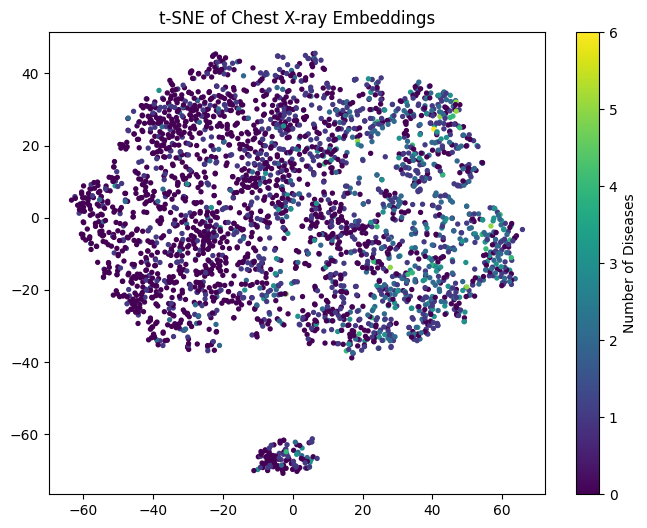

In [166]:
import matplotlib.pyplot as plt

num_diseases = labels_subset.sum(axis=1)

plt.figure(figsize=(8,6))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=num_diseases,
    cmap='viridis',
    s=8
)
plt.colorbar(label="Number of Diseases")
plt.title("t-SNE of Chest X-ray Embeddings")
plt.show()


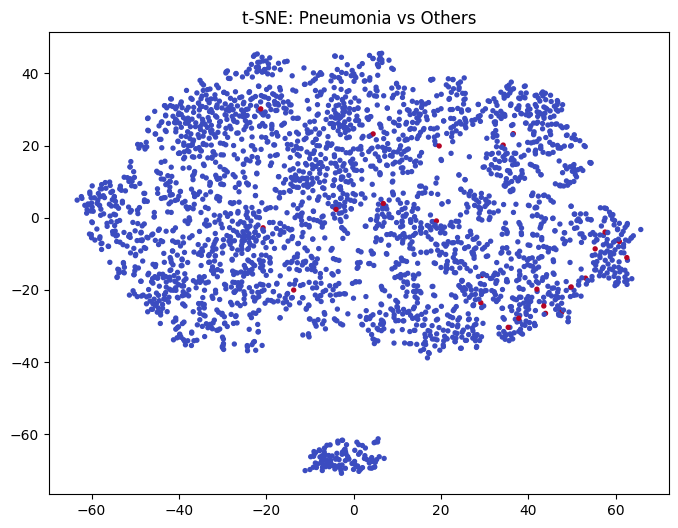

In [167]:
pneumonia_idx = labels_subset[:, diseases.index("Pneumonia")]

plt.figure(figsize=(8,6))
plt.scatter(
    emb_2d[:,0],
    emb_2d[:,1],
    c=pneumonia_idx,
    cmap='coolwarm',
    s=8
)
plt.title("t-SNE: Pneumonia vs Others")
plt.show()


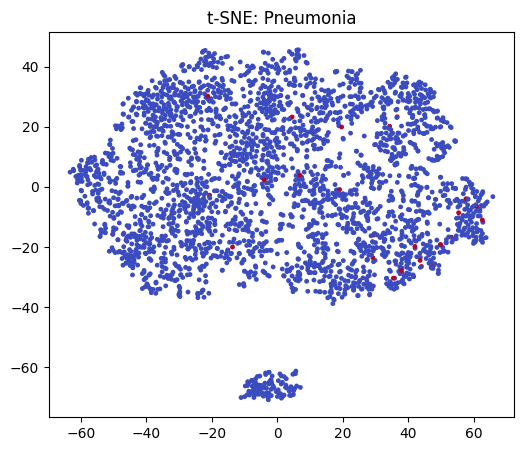

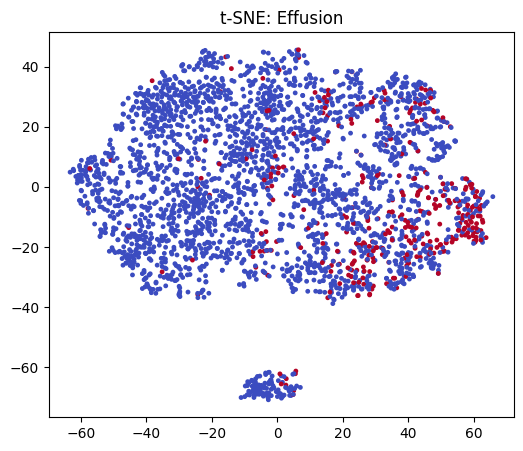

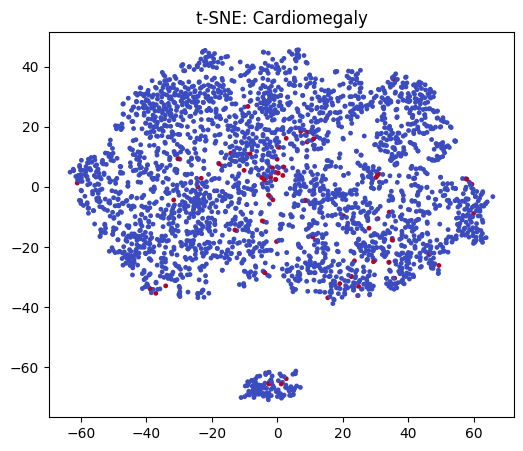

In [169]:
for d in ["Pneumonia", "Effusion", "Cardiomegaly"]:
    idx = labels_subset[:, diseases.index(d)]

    plt.figure(figsize=(6,5))
    plt.scatter(
        emb_2d[:,0],
        emb_2d[:,1],
        c=idx,
        cmap='coolwarm',
        s=6
    )
    plt.title(f"t-SNE: {d}")
    plt.show()


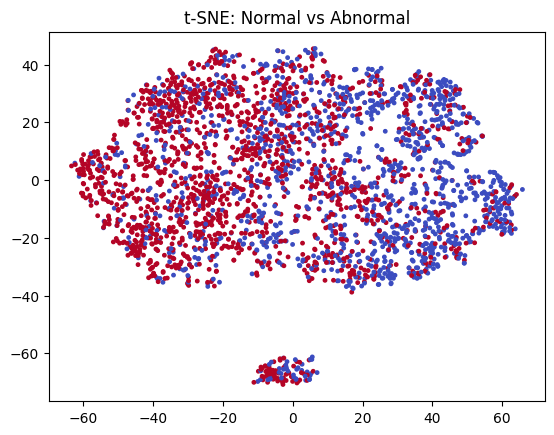

In [170]:
normal = (labels_subset.sum(axis=1) == 0).astype(int)

plt.scatter(
    emb_2d[:,0],
    emb_2d[:,1],
    c=normal,
    cmap='coolwarm',
    s=6
)
plt.title("t-SNE: Normal vs Abnormal")
plt.show()


Trying different losses

In [68]:
import torch.nn as nn

def make_linear_head(dim, num_classes):
    return nn.Linear(dim, num_classes).to(device)


In [79]:

criterion_bce = nn.BCEWithLogitsLoss()


In [173]:
model_0 = make_linear_head(X_train.shape[1], 14)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(20):
    optimizer.zero_grad()
    logits = model_0(X_train)
    loss = criterion_bce(logits, y_train)
    loss.backward()
    optimizer.step()


In [174]:
from sklearn.metrics import roc_auc_score
import numpy as np

def eval_auc(model, X, y):
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X)).cpu().numpy()
    y_true = y.cpu().numpy()

    aucs = []
    for i in range(y_true.shape[1]):
        if len(np.unique(y_true[:, i])) > 1:
            aucs.append(roc_auc_score(y_true[:, i], probs[:, i]))
    return np.mean(aucs)


In [175]:
eval_auc(model_0,X_val,y_val)

0.4657459590548214

In [83]:
y_train = torch.tensor(
    train_df[diseases].values,
    dtype=torch.float32
).to(device)


In [84]:
import torch

pos_counts = y_train.sum(dim=0)              # positives per disease
neg_counts = y_train.shape[0] - pos_counts   # negatives

pos_weight = neg_counts / (pos_counts + 1e-6)
pos_weight = pos_weight.to(device)


In [85]:
criterion_wbce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [178]:
model_1 = make_linear_head(X_train.shape[1], 14)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(20):
    optimizer.zero_grad()
    logits = model_1(X_train)
    loss = criterion_wbce(logits, y_train)
    loss.backward()
    optimizer.step()

In [179]:
eval_auc(model_1,X_val,y_val)

0.47325261065781615

In [73]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        focal = (1 - probs) ** self.gamma
        return (focal * bce).mean()


In [82]:
criterion_focal = FocalLoss(gamma=2)


In [182]:
model_2 = make_linear_head(X_train.shape[1], 14)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(20):
    optimizer.zero_grad()
    logits = model_2(X_train)
    loss = criterion_focal(logits, y_train)
    loss.backward()
    optimizer.step()

In [183]:
eval_auc(model_2,X_val,y_val)

0.4758621058677551

In [184]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4, clip=0.05):
        super().__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)

        if self.clip > 0:
            probs = torch.clamp(probs, self.clip, 1 - self.clip)

        pos_loss = targets * torch.log(probs)
        neg_loss = (1 - targets) * torch.log(1 - probs)

        pos_weight = (1 - probs) ** self.gamma_pos
        neg_weight = probs ** self.gamma_neg

        loss = - (pos_weight * pos_loss + neg_weight * neg_loss)
        return loss.mean()


In [185]:
criterion_asl = AsymmetricLoss(gamma_pos=0, gamma_neg=4)
loss_asl=criterion_asl

In [186]:
model_3 = make_linear_head(X_train.shape[1], 14)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(20):
    optimizer.zero_grad()
    logits = model_3(X_train)
    loss = criterion_asl(logits, y_train)
    loss.backward()
    optimizer.step()

In [187]:
eval_auc(model_3,X_val,y_val)

0.5059114367306731

In [188]:
probs_bce = torch.sigmoid(model_0(X_val)).cpu().detach().numpy()
probs_wbce = torch.sigmoid(model_1(X_val)).cpu().detach().numpy()
probs_focal = torch.sigmoid(model_2(X_val)).cpu().detach().numpy()
probs_asl = torch.sigmoid(model_3(X_val)).cpu().detach().numpy()


# Types of losses

In [189]:
results = {}

# Example structure
results["BCE"] = probs_bce        # shape (N, 14)
results["WBCE"] = probs_wbce
results["Focal"] = probs_focal
results["ASL"] = probs_asl


In [190]:
results.items()

dict_items([('BCE', array([[0.4631122 , 0.48259744, 0.41508624, ..., 0.54228973, 0.5043689 ,
        0.57219875],
       [0.5717358 , 0.5253568 , 0.41484118, ..., 0.5247156 , 0.5743261 ,
        0.5426596 ],
       [0.5781421 , 0.48909515, 0.47186956, ..., 0.45125812, 0.63599813,
        0.6256857 ],
       ...,
       [0.55794984, 0.4911279 , 0.43822768, ..., 0.46258357, 0.6419043 ,
        0.6100985 ],
       [0.54594743, 0.47925997, 0.45692354, ..., 0.46795174, 0.5685323 ,
        0.5976353 ],
       [0.5691499 , 0.4856289 , 0.45488605, ..., 0.46047017, 0.5926954 ,
        0.60129976]], dtype=float32)), ('WBCE', array([[0.5805719 , 0.49217886, 0.48097003, ..., 0.5442695 , 0.52088594,
        0.5333265 ],
       [0.6075105 , 0.4886021 , 0.51665556, ..., 0.51960945, 0.5176829 ,
        0.49061924],
       [0.6413646 , 0.48230475, 0.44496292, ..., 0.5647341 , 0.55733776,
        0.53378445],
       ...,
       [0.6221359 , 0.51411456, 0.45302898, ..., 0.55717367, 0.5399095 ,
        0.

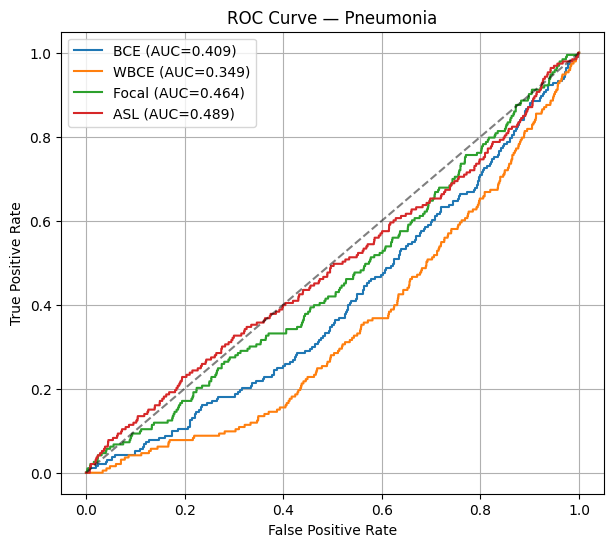

In [191]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

disease_idx = diseases.index("Pneumonia")

plt.figure(figsize=(7,6))
y_val_np = y_val.cpu().numpy()   # (N, 14)

for loss_name, probs in results.items():
    fpr, tpr, _ = roc_curve(
        y_val_np[:, disease_idx],
        probs[:, disease_idx]
    )
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{loss_name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Pneumonia")
plt.legend()
plt.grid(True)
plt.show()


In [192]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def macro_roc(y_true, y_prob, num_classes=14):
    fprs, tprs = [], []

    for i in range(num_classes):
        if len(np.unique(y_true[:, i])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        fprs.append(fpr)
        tprs.append(tpr)

    # Interpolate
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([
        np.interp(mean_fpr, fpr, tpr)
        for fpr, tpr in zip(fprs, tprs)
    ], axis=0)

    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc


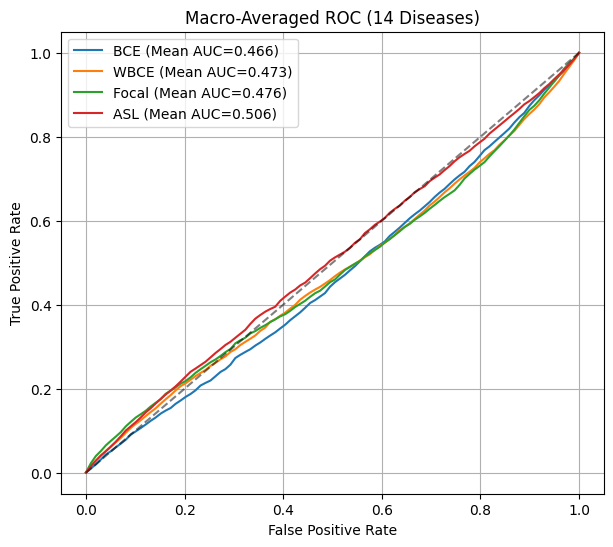

In [193]:
plt.figure(figsize=(7,6))

for loss_name, probs in results.items():
    fpr, tpr, mean_auc = macro_roc(y_val_np, probs)
    plt.plot(fpr, tpr, label=f"{loss_name} (Mean AUC={mean_auc:.3f})")

plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC (14 Diseases)")
plt.legend()
plt.grid(True)
plt.show()


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SupConLossMultiLabel(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, embeddings, labels):
        device = embeddings.device
        B = embeddings.size(0)

        embeddings = F.normalize(embeddings, dim=1)

        # Cosine similarity
        sim = torch.matmul(embeddings, embeddings.T) / self.temperature
        sim = sim - torch.max(sim, dim=1, keepdim=True)[0]

        # Positive mask: share at least one label
        label_sim = (labels @ labels.T) > 0
        label_sim = label_sim.float().to(device)

        # Remove self-contrast
        mask = torch.eye(B, device=device)
        label_sim = label_sim * (1 - mask)

        # 🚨 CRITICAL FIX: no positive pairs
        if label_sim.sum().item() == 0:
            return torch.zeros(1, device=device, requires_grad=True).squeeze()

        exp_sim = torch.exp(sim) * (1 - mask)
        log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)

        mean_log_prob_pos = (
            (label_sim * log_prob).sum(dim=1) /
            (label_sim.sum(dim=1) + 1e-8)
        )

        loss = -mean_log_prob_pos.mean()
        return loss


In [ ]:
train_emb.shape

In [ ]:
train_emb[0]

In [ ]:
train_emb[0]

In [ ]:
for i in range (20):
    print(np.sum(train_emb[i,:],axis=0))

In [86]:

criterion_supcon = SupConLossMultiLabel(temperature=0.07)


In [ ]:
labels.shape

In [ ]:
logits.shape

In [ ]:
embeddings.shape

In [196]:
lambda_supcon = 0.1

for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device).float()

    optimizer.zero_grad()

    # ---- Forward ----
    embeddings = model.get_embedding(images)   # ✅ CORRECT
    logits = model(images)

    # ---- Losses ----
    loss_cls = criterion_asl(logits, labels)
    loss_con = criterion_supcon(embeddings, labels)

    loss = loss_cls + lambda_supcon * loss_con

    # ---- Backprop ----
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()


KeyboardInterrupt: 

In [197]:
model.eval()

DenseNet121_new(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mom

In [200]:
import torch
import numpy as np

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        logits = model(images)                 # (B, 14)
        probs = torch.sigmoid(logits)          # probabilities

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

y_prob = torch.cat(all_probs).numpy()   # (N, 14)
y_true = torch.cat(all_labels).numpy()  # (N, 14)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7aa6152980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7aa6152980>
 ^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^  ^^^^^^^^^^^^

In [201]:
from sklearn.metrics import roc_auc_score

disease_aucs = {}

for i, disease in enumerate(diseases):
    # # Some diseases may have only one class in val split
    # if len(np.unique(y_true[:, i])) < 2:
    #     continue

    disease_aucs[disease] = roc_auc_score(
        y_true[:, i],
        y_prob[:, i]
    )
    print(disease_aucs[disease])
# mean_auc = np.mean(list(disease_aucs.values()))
# print("Mean AUROC:", mean_auc)

# disease_auc[disease]

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


In [202]:
import numpy as np

# y_train: (N, 14) numpy array or torch -> convert to numpy
Y = y_train.cpu().numpy()

co_occurrence = Y.T @ Y        # (14, 14)
co_occurrence = co_occurrence / co_occurrence.max()

np.fill_diagonal(co_occurrence, 0)


In [ ]:
y_train.shape

In [ ]:
mask

In [204]:
prototypes = {}

for i, disease in enumerate(diseases):
    mask = (y_train[:, i] == 1)          # shape: (N,)
    
    # train_emb: (N, 1024)
    disease_embs = train_emb[mask]       # (N_d, 1024)
    
    prototypes[disease] = disease_embs.mean(axis=0)  # (1024,)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
train_emb="/kaggle/working/train_embeddings.npy"

In [ ]:
train_emb=np.load(train_emb)

In [ ]:
train_emb.shape

In [ ]:
y_train[52]

In [ ]:
train_emb.shape

In [ ]:
train_emb = torch.tensor(train_emb, dtype=torch.float32).to(device)


In [ ]:
type(prototypes)

In [ ]:
prototypes

In [ ]:
prototypes=prototypes.to_device()

In [ ]:
proto_matrix.shape

In [ ]:
import torch.nn.functional as F
import torch

# Use torch.as_tensor() to automatically handle NumPy types
proto_matrix = torch.stack([torch.as_tensor(prototypes[d]) for d in diseases])
  # (14, 1024)

# Normalize
proto_matrix = F.normalize(proto_matrix, dim=1)

# Cosine similarity matrix
proto_sim = proto_matrix @ proto_matrix.T   # (14, 14)

# Zero diagonal
proto_sim.fill_diagonal_(0)


In [ ]:
# Ensure both are torch tensors on the same device
co_occurrence = torch.tensor(co_occurrence, dtype=torch.float32).to(device)
# proto_sim is already torch on GPU
proto_sim=torch.tensor(proto_sim, dtype=torch.float32).to(device)
A = 0.5 * co_occurrence + 0.5 * proto_sim


In [ ]:
import torch
threshold = 0.1

edges = torch.where(A > threshold)      # (row_idx, col_idx)
edge_index = torch.stack(edges, dim=0)  # (2, E)
edge_index = edge_index.to(device)


In [ ]:
node_features = torch.tensor(proto_matrix, dtype=torch.float32).to(device)
# shape: (14, 1024)


In [ ]:
pip install torch torch-geometric


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class DiseaseGNN(nn.Module):
    def __init__(self, in_dim=1024, hidden_dim=256):
        super().__init__()
        
        self.gcn1 = GCNConv(in_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        return x   # (14, hidden_dim)


In [ ]:
gnn = DiseaseGNN().to(device)


In [ ]:
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device).float()

    optimizer.zero_grad()

    # CNN
    embeddings = model.get_embedding(images)
    logits_img = model(images)

    # GNN
    node_repr = gnn(node_features, edge_index)
    logits_gnn = logits_img + logits_img @ A

    # Losses
    loss_cls = criterion_asl(logits_gnn, labels)
    loss_con = criterion_supcon(embeddings, labels)

    loss = loss_cls + lambda_supcon * loss_con

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()


In [ ]:
model.eval()
gnn.eval()
    

In [ ]:
y_prob[:,:]

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        logits_img = model(images)
        logits_gnn = logits_img + logits_img @ A

        probs = torch.sigmoid(logits_gnn)

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

y_prob = torch.cat(all_probs).numpy()
y_true = torch.cat(all_labels).numpy()

aucs = []
for i in range(y_true.shape[1]):
    if len(np.unique(y_true[:, i])) > 1:
        aucs.append(roc_auc_score(y_true[:, i], y_prob[:, i]))

print("Mean AUROC (CNN + GNN):", np.mean(aucs))


In [ ]:
torch.save({
    "cnn": model.state_dict(),
    "gnn": gnn.state_dict(),
    "A": A
}, "phase1_vision_graph.pth")


In [ ]:
all_embs = []
all_labels = []
c=0
with torch.no_grad():
    for images, labels in train_loader:
        c=c+1
        if(c%500==0):
            print(c)
        images = images.to(device)
        labels = labels.to(device)

        emb = model.get_embedding(images)

        all_embs.append(emb.cpu())
        all_labels.append(labels.cpu())

train_emb = torch.cat(all_embs)
y_train  = torch.cat(all_labels)


In [ ]:
print("Images NaN:", torch.isnan(images).any().item())
print("Images Inf:", torch.isinf(images).any().item())
print("Images min/max:", images.min().item(), images.max().item())


In [ ]:
ckpt = torch.load("/kaggle/input/nih-chest-xray/pytorch/default/1/best_densenet121.pth", map_location=device)
model.load_state_dict(ckpt, strict=False)
model.eval()


In [ ]:
model.eval()
with torch.no_grad():
    raw_feat = model.backbone.features(images)

print("Raw features NaN:", torch.isnan(raw_feat).any().item())
print("Raw features Inf:", torch.isinf(raw_feat).any().item())
print("Raw min/max:", raw_feat.min().item(), raw_feat.max().item())


In [ ]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    features = model.backbone.features(images)
    features = torch.relu(features)

B, C, H, W = features.shape

patches = features.permute(0, 2, 3, 1).reshape(B, H*W, C)

# ---- CRITICAL FIX: handle zero vectors explicitly ----
patch_norms = torch.norm(patches, dim=-1, keepdim=True)

# mask zero-norm patches
valid_mask = patch_norms > 1e-6

patches = patches / (patch_norms + 1e-6)
patches = patches * valid_mask  # zero out invalid patches


In [ ]:
proto = prototypes["Pneumonia"].to(device)

print("Proto norm:", torch.norm(proto).item())
print("Proto NaN:", torch.isnan(proto).any().item())

# ---- CRITICAL FIX ----
if torch.norm(proto) < 1e-6 or torch.isnan(proto).any():
    raise ValueError("Prototype is invalid (zero or NaN)")

proto = proto / (torch.norm(proto) + 1e-6)


In [ ]:
prototypes = {}

for i, disease in enumerate(diseases):
    mask = (y_train[:, i] == 1)
    prototypes[disease] = train_emb[mask].mean(dim=0)


In [ ]:
# with torch.no_grad():
#     features = model.backbone.features(images)
#     features = torch.relu(features)
model.eval()
with torch.no_grad():
    features = model.backbone.features(images)
    features = torch.relu(features)


In [ ]:
B, C, H, W = features.shape
patches = features.permute(0, 2, 3, 1).reshape(B, H*W, C)
patches = torch.nn.functional.normalize(patches, dim=-1)


In [ ]:
proto = torch.nn.functional.normalize(
    prototypes["Pneumonia"].to(device), dim=0
)

heatmap = (patches[0] @ proto).reshape(H, W)
heatmap = torch.nn.functional.interpolate(
    heatmap.unsqueeze(0).unsqueeze(0),
    size=(224,224),
    mode="bilinear",
    align_corners=False
).squeeze()


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[0].cpu().permute(1,2,0), cmap="gray")
plt.imshow(heatmap.cpu(), alpha=0.5, cmap="jet")
plt.title("Pneumonia localization")
plt.axis("off")
plt.show()


In [ ]:
print("Feature map stats:")
print("min:", features.min().item())
print("max:", features.max().item())
print("mean:", features.mean().item())
print("NaNs:", torch.isnan(features).any())


In [ ]:
print("Heatmap min:", heatmap.min().item())
print("Heatmap max:", heatmap.max().item())
print("Heatmap mean:", heatmap.mean().item())


In [ ]:
graph = {
    "diseases": {},   # disease nodes
    "images": {},     # image nodes
    "patches": {},    # patch nodes
    "edges": []       # all relations
}


In [ ]:
import torch

for i, d in enumerate(diseases):
    graph["diseases"][d] = {
        "id": f"disease::{d}",
        "embedding": proto_matrix[i].cpu(),   # (1024,)
        "index": i,
        "type": "disease"
    }


disease to disease edges

In [ ]:
threshold = 0.2   # tune later

for i, d1 in enumerate(diseases):
    for j, d2 in enumerate(diseases):
        if i != j and A[i, j] > threshold:
            graph["edges"].append({
                "src": f"disease::{d1}",
                "dst": f"disease::{d2}",
                "weight": float(A[i, j].item()),
                "type": "disease_relation"
            })


image node+image->disease edges

In [ ]:
import torch.nn.functional as F

image_id = 0
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)

        emb = model.get_embedding(images)     # (B, 1024)
        logits = model(images)                # (B, D)
        probs = torch.sigmoid(logits)

        for i in range(images.size(0)):
            img_key = f"image::{image_id}"

            graph["images"][img_key] = {
                "id": img_key,
                "embedding": emb[i].cpu(),
                "type": "image"
            }

            # image → disease edges
            for d_idx, d in enumerate(diseases):
                conf = probs[i, d_idx].item()
                if conf > 0.5:
                    graph["edges"].append({
                        "src": img_key,
                        "dst": f"disease::{d}",
                        "weight": conf,
                        "type": "image_prediction"
                    })

            image_id += 1


In [ ]:
patch_id = 0
TOP_K = 2   # number of patches per disease per image
q=0
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        q=q+1
        if (q%100==0):
            print(q)
        # feature map
        features = model.backbone.features(images)
        features = torch.relu(features)

        B, C, H, W = features.shape

        patches = features.permute(0,2,3,1).reshape(B, H*W, C)
        patches = patches / (torch.norm(patches, dim=-1, keepdim=True) + 1e-6)

        # similarity: (B, D, HW)
        sim = torch.einsum("bhc,dc->bdh", patches, proto_matrix.to(device))

        for b in range(B):
            img_key = f"image::{patch_id // (TOP_K * len(diseases))}"

            for d_idx, d in enumerate(diseases):
                vals, idxs = torch.topk(sim[b, d_idx], TOP_K)

                for score, idx in zip(vals, idxs):
                    y = (idx // W).item()
                    x = (idx % W).item()

                    patch_key = f"patch::{patch_id}"

                    graph["patches"][patch_key] = {
                        "id": patch_key,
                        "image": img_key,
                        "location": (x, y),
                        "score": float(score.item()),
                        "disease": d,
                        "type": "patch"
                    }

                    # patch → disease
                    graph["edges"].append({
                        "src": patch_key,
                        "dst": f"disease::{d}",
                        "weight": float(score.item()),
                        "type": "visual_evidence"
                    })

                    # patch → image
                    graph["edges"].append({
                        "src": patch_key,
                        "dst": img_key,
                        "weight": 1.0,
                        "type": "grounded_in"
                    })

                    patch_id += 1


In [ ]:
import pickle

with open("graph_rag_index.pkl", "wb") as f:
    pickle.dump(graph, f)

print("✅ Graph-RAG index saved")


In [ ]:
def get_disease_node(graph, disease):
    return graph["diseases"].get(disease)


In [ ]:
def get_related_diseases(graph, disease, top_k=5):
    src = f"disease::{disease}"
    
    rels = []
    for e in graph["edges"]:
        if e["type"] == "disease_relation" and e["src"] == src:
            rels.append((e["dst"], e["weight"]))
    
    rels = sorted(rels, key=lambda x: x[1], reverse=True)
    return rels[:top_k]


In [ ]:
def get_supporting_images(graph, disease, min_conf=0.5, top_k=5):
    dst = f"disease::{disease}"
    
    imgs = []
    for e in graph["edges"]:
        if e["type"] == "image_prediction" and e["dst"] == dst:
            imgs.append((e["src"], e["weight"]))
    
    imgs = sorted(imgs, key=lambda x: x[1], reverse=True)
    return imgs[:top_k]


In [ ]:
def get_visual_evidence(graph, disease, top_k=5):
    evidences = []
    
    for patch_id, patch in graph["patches"].items():
        if patch["disease"] == disease:
            evidences.append((
                patch_id,
                patch["image"],
                patch["location"],
                patch["score"]
            ))
    
    evidences = sorted(evidences, key=lambda x: x[3], reverse=True)
    return evidences[:top_k]


In [ ]:
def retrieve_for_reasoning(graph, disease):
    return {
        "disease": disease,
        "related_diseases": get_related_diseases(graph, disease),
        "supporting_images": get_supporting_images(graph, disease),
        "visual_evidence": get_visual_evidence(graph, disease)
    }


In [ ]:
def build_llm_prompt(context):
    """
    context = output of retrieve_for_reasoning()
    """
    disease = context["disease"]

    related = ", ".join([
        d.replace("disease::", "") for d, _ in context["related_diseases"]
    ])

    images = ", ".join([
        img.replace("image::", "") for img, _ in context["supporting_images"]
    ])

    evidence_lines = []
    for patch_id, img, loc, score in context["visual_evidence"]:
        evidence_lines.append(
            f"- Patch at location {loc} in {img} with similarity score {score:.2f}"
        )

    evidence_text = "\n".join(evidence_lines)

    prompt = f"""
You are a medical imaging reasoning assistant.

Disease under consideration:
{disease}

Related diseases based on learned medical graph:
{related}

Supporting images with high confidence predictions:
{images}

Localized visual evidence:
{evidence_text}

Task:
Using ONLY the information above, explain:
1. Why {disease} is predicted
2. How the visual evidence supports this diagnosis
3. How related diseases are medically connected

Do NOT introduce any new diseases or assumptions.
Provide a concise, clinically grounded explanation.
"""
    return prompt


In [ ]:
context = retrieve_for_reasoning(graph, "Pneumonia")


In [ ]:
context

In [ ]:
prompt = build_llm_prompt(context)



In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("OPENAI_API_KEY")

In [ ]:
secret_value_0

In [ ]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

if os.getenv("OPEN_AI_API_KEY") is None:
    raise ValueError("OPEN_AI_API_KEY environment variable not set.")


client = OpenAI(api_key=os.getenv("OPEN_AI_API_KEY"))

response = client.chat.completions.create(
    model="gpt-4o-mini",   # or any model
    messages=[
        {"role": "system", "content": "You are a medical imaging assistant."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.2
)

print(response.choices[0].message.content)


In [ ]:
import torch

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")


In [ ]:
ckpt = torch.load("/kaggle/working/phase1_vision_graph.pth", map_location=device)

model.load_state_dict(ckpt["cnn"])
model.eval()

proto_matrix = ckpt["proto_matrix"].to(device)
A = ckpt["adjacency"].to(device)
diseases = ckpt["diseases"]
